# Классификатор изображений

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTConfig

Импорт датасета

In [36]:
direction = 'C:/Users/Delta-Game/Desktop/Jupyter_projects/MentorEx/cifar10' # путь к папке данных

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

## Трансформеры

## Vanilla Vision Transformer (ViT)
предобученная

In [41]:
# Параметры
num_classes = 10
batch_size = 64 # 8x8 батч
epochs = 5
learning_rate = 1e-4

# Проверка CUDA
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}, CUDA version: {torch.version.cuda}")
else:
    print("GPU not available, using CPU")
    
# Transforms: Resize to 224x224 (ViT ожидает это), нормализация ImageNet
transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])  # CIFAR-10 stats
])


# Загрузка датасета из локальной папки
train_dataset = datasets.ImageFolder(
    root=direction+'/train',
    transform=transform
)
test_dataset = datasets.ImageFolder(
    root=direction+'/test',
    transform=transform
)
# DataLoader для батчей
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Проверка
print("Train classes:", train_dataset.classes)
print("Number of train images:", len(train_dataset))
print("Number of test images:", len(test_dataset))

CUDA available: True
GPU: NVIDIA GeForce RTX 2080 SUPER, CUDA version: 11.8
Train classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of train images: 50000
Number of test images: 10000


In [38]:
try:
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224',
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
        cache_dir='C:/Users/Delta-Game/Desktop/Jupyter_projects/MentorEx/cache',
        local_files_only=False
    )
except Exception as e:
    print(f"Ошибка загрузки модели: {e}")
    print("Проверь интернет, установи 'hf_xet' или проверь кэш.")
    exit()

model.to(device)
print(f"Model device: {next(model.parameters()).device}")

# Loss и optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Добавлено сглаживание
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Списки для метрик
train_losses = []
test_accuracies = []

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model device: cuda:0


In [40]:
# Обучение
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        if i == 0:  # Проверка устройства для первого батча
            print(f"Epoch {epoch+1}, Images device: {images.device}, Labels device: {labels.device}")
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Тестирование
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")



Epoch 1, Images device: cuda:0, Labels device: cuda:0
Epoch 1/10, Loss: 0.5695, LR: 0.000100
Test Accuracy: 96.96%
Epoch 2, Images device: cuda:0, Labels device: cuda:0
Epoch 2/10, Loss: 0.5340, LR: 0.000010
Test Accuracy: 98.02%
Epoch 3, Images device: cuda:0, Labels device: cuda:0


KeyboardInterrupt: 

In [ ]:
# Финальный результат
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# CNN

In [26]:
num_classes = 10
batch_size = 64
epochs = 50
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = 'C:/Users/Delta-Game/Desktop/Jupyter_projects/MentorEx/cifar10/train'
test_dir = 'C:/Users/Delta-Game/Desktop/Jupyter_projects/MentorEx/cifar10/test'

In [27]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Принудительно 32x32
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])
])

In [28]:
# Проверка размера изображения
sample_img_path = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
sample_img = Image.open(sample_img_path)
print(f"Sample image size: {sample_img.size}")  # Должно быть (32, 32)

Sample image size: (32, 32)


In [29]:
# Загрузка датасета
try:
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
except Exception as e:
    raise RuntimeError(f"Failed to load dataset: {e}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Проверка данных
print("Train classes:", train_dataset.classes)
print("Number of train images:", len(train_dataset))
print("Number of test images:", len(test_dataset))
if len(train_dataset.classes) != 10:
    raise ValueError(f"Expected 10 classes, got {len(train_dataset.classes)}")

# Проверка размера первого тензора
sample_image, _ = train_dataset[0]
print(f"Sample tensor shape: {sample_image.shape}")  # Должно быть [3, 32, 32]


Train classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of train images: 50000
Number of test images: 10000
Sample tensor shape: torch.Size([3, 32, 32])


In [32]:
# Определение CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256 * 8 * 8, num_classes)  # 256 * 8 * 8 = 16384
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Архитектура: 3 блока (Conv2D → BatchNorm → ReLU → MaxPool), затем Flatten → Dropout → FC.  
Размеры: 32x32 → 16x16 → 8x8 → 25688=16384 → 10.  
Dropout(0.5): Регуляризация для малого датасета.  

In [33]:
# Инициализация модели
model = SimpleCNN(num_classes=num_classes).to(device)
print(f"Model device: {next(model.parameters()).device}")
print(f"Conv1 filters shape: {model.conv1.weight.shape}")

# Loss, optimizer и scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Списки для метрик
train_losses = []
test_accuracies = []

# Обучение
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        if i == 0:
            print(f"Epoch {epoch+1}, Images device: {images.device}, Labels device: {labels.device}")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i == 0:  # Отключить print после первого батча
            model.forward = model.__class__.forward.__get__(model, model.__class__)
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Тестирование
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")

# Финальный результат
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%") # Final Test Accuracy: 86.87%

Model device: cuda:0
Conv1 filters shape: torch.Size([64, 3, 3, 3])
Epoch 1, Images device: cuda:0, Labels device: cuda:0
Epoch 1/50, Loss: 1.8083, LR: 0.001000
Test Accuracy: 54.74%
Epoch 2, Images device: cuda:0, Labels device: cuda:0
Epoch 2/50, Loss: 1.4145, LR: 0.001000
Test Accuracy: 61.97%
Epoch 3, Images device: cuda:0, Labels device: cuda:0
Epoch 3/50, Loss: 1.3123, LR: 0.001000
Test Accuracy: 66.09%
Epoch 4, Images device: cuda:0, Labels device: cuda:0
Epoch 4/50, Loss: 1.2476, LR: 0.001000
Test Accuracy: 68.86%
Epoch 5, Images device: cuda:0, Labels device: cuda:0
Epoch 5/50, Loss: 1.1975, LR: 0.001000
Test Accuracy: 72.46%
Epoch 6, Images device: cuda:0, Labels device: cuda:0
Epoch 6/50, Loss: 1.1595, LR: 0.001000
Test Accuracy: 73.79%
Epoch 7, Images device: cuda:0, Labels device: cuda:0
Epoch 7/50, Loss: 1.1270, LR: 0.001000
Test Accuracy: 75.10%
Epoch 8, Images device: cuda:0, Labels device: cuda:0
Epoch 8/50, Loss: 1.0981, LR: 0.001000
Test Accuracy: 74.86%
Epoch 9, Ima

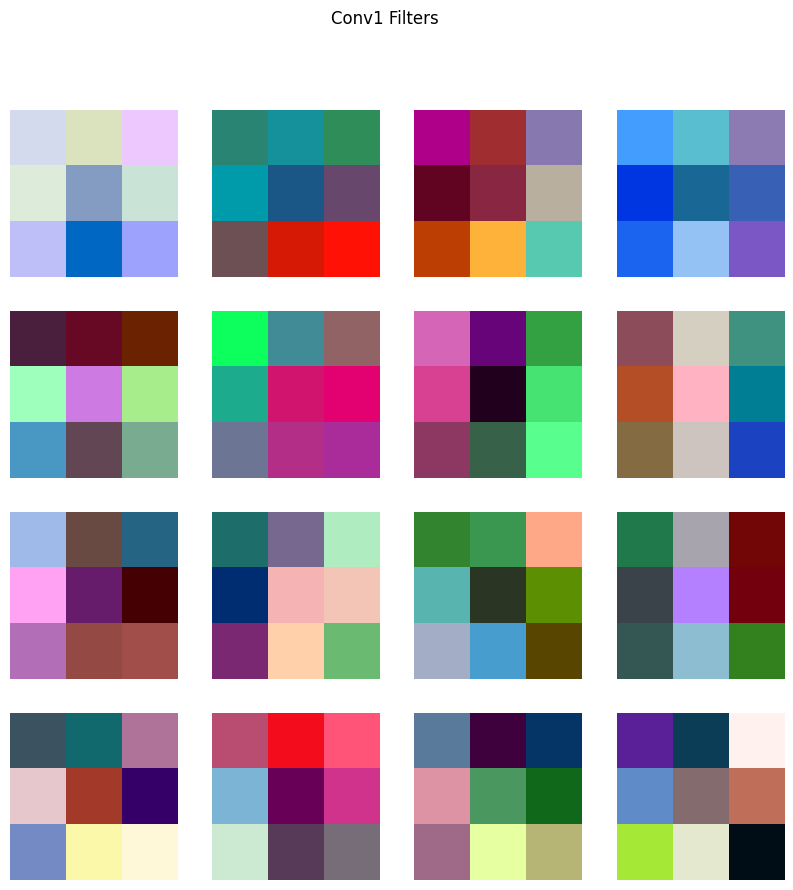

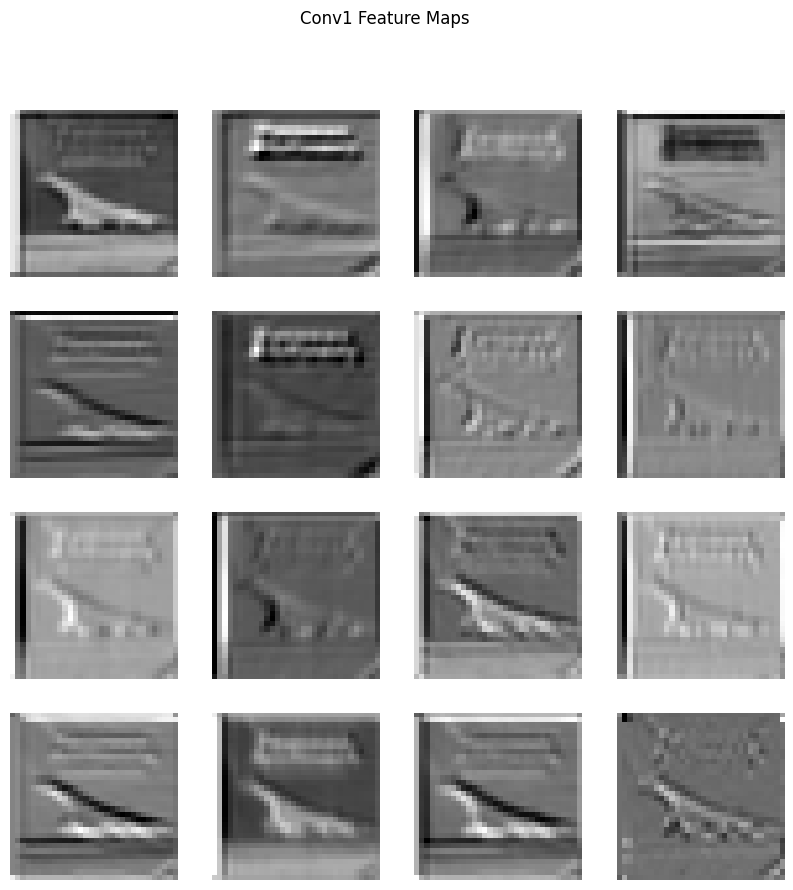

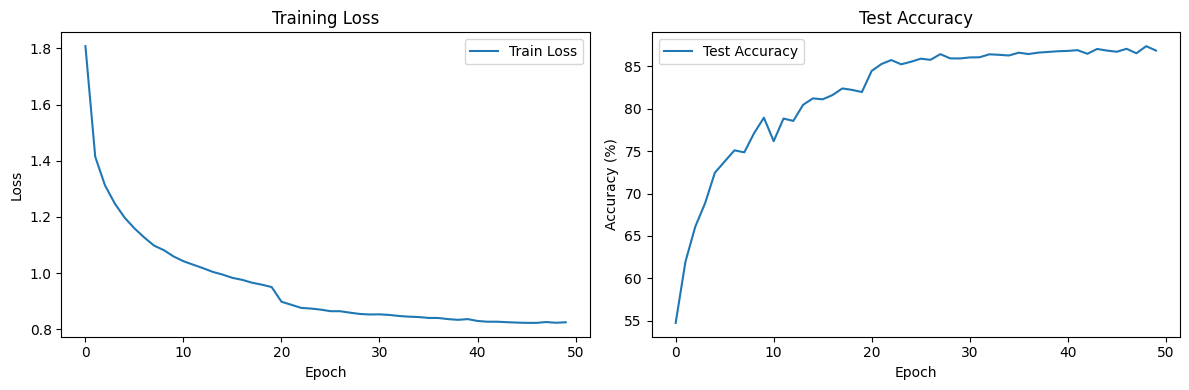

In [34]:
#  Визуализация фильтров
filters = model.conv1.weight.detach().cpu().numpy()
plt.figure(figsize=(10, 10))
for i in range(min(16, filters.shape[0])):
    plt.subplot(4, 4, i+1)
    filter_rgb = filters[i].transpose(1, 2, 0)
    filter_rgb = (filter_rgb - filter_rgb.min()) / (filter_rgb.max() - filter_rgb.min())
    plt.imshow(filter_rgb)
    plt.axis('off')
plt.suptitle('Conv1 Filters')
plt.show()

# Визуализация feature maps
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    conv1_output = model.conv1(images[0:1]).cpu().numpy()
    plt.figure(figsize=(10, 10))
    for i in range(min(16, conv1_output.shape[1])):
        plt.subplot(4, 4, i+1)
        plt.imshow(conv1_output[0, i], cmap='gray')
        plt.axis('off')
    plt.suptitle('Conv1 Feature Maps')
    plt.show()

# Визуализация метрик
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import torch
print(torch.cuda.is_available())  # Должно вернуть True
print(torch.__version__)  # Проверьте версию PyTorch

True
2.5.1+cu121
